### Squeeze and excitation [block](https://arxiv.org/abs/1709.01507) in ResNet architecture.

CNNs use their convolutional filters to extract hierarchal information from image, but even last layers have smaller receptive field than input image, thereforce each pixel will not takeы into account all channel and spatial information.

All of this works by fusing the spatial and channel information of an image. The different filters will first find spatial features in each input channel before adding the information across all available output channels.
<img src='pictures/se_block.png'>
____________
## __Squeeze block__ 
First, they get a global understanding of each channel by squeezing the feature maps to a single numeric value. This results in a vector of size n, where n is equal to the number of convolutional channels. 
<img src='pictures/squeeze.png'>
## __Excitation block__
Afterwards, it is fed through a two-layer neural network, which outputs a vector of the same size. These n values can now be used as weights on the original features maps, scaling each channel based on its importance.
<img src='pictures/exictation.png'>

To more information you can read [this](https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7).

In [1]:
import os
import sys

import blosc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pandas import ewma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline

sys.path.append('../..')
sys.path.append('..')

import utils
from dataset import B,V,F
from dataset.dataset.opensets import MNIST
from dataset.dataset.models.tf import ResNet

In [2]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

As always, first of all, we create batch class and config to create placeholders

In [3]:
dset = MNIST()

ExtractingExtracting /tmp/train-images-idx3-ubyte.gz 
/tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [4]:
placeholders_config = {
                       'images': {'shape': (28, 28, 1)},
                
                       'labels': {'classes': (10),
                                  'transform': 'ohe',
                                  'dtype': 'int32',
                                  'name': 'targets'}
                       }

And config to our model

In [5]:
ResNet_config = {'inputs': placeholders_config,
                 'input_block/inputs': 'images',
                 'body/num_blocks': [1, 1, 1, 1],
                 'body/filters': [64, 128, 256, 512],
                 'loss': 'softmax_cross_entropy',
                 'optimizer': 'Adam',
                 'body/block/bottleneck': 1} 
Bottlenet_config = {**ResNet_config, 'body/block/se_block': 1}

In [6]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

As last time, we use a ready-made model from dataset models.

In [7]:
res_train_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet,
                      'resnet',
                      config=ResNet_config)
           .train_model('resnet',
                        feed_dict=placehold_dict))
res_test_ppl = (dset.test
           .p
           .init_variable('resloss', init_on_each_run=list)
           .import_model('resnet', res_train_ppl)
           .predict_model('resnet',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('resloss'), mode='a'))

In [8]:
se_train_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet,
                      'se_block',
                      config=Bottlenet_config)
           .train_model('se_block',
                        feed_dict=placehold_dict))
se_test_ppl = (dset.test
           .p
           .init_variable('seloss', init_on_each_run=list)
           .import_model('se_block', se_train_ppl)
           .predict_model('se_block',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('seloss'), mode='a'))

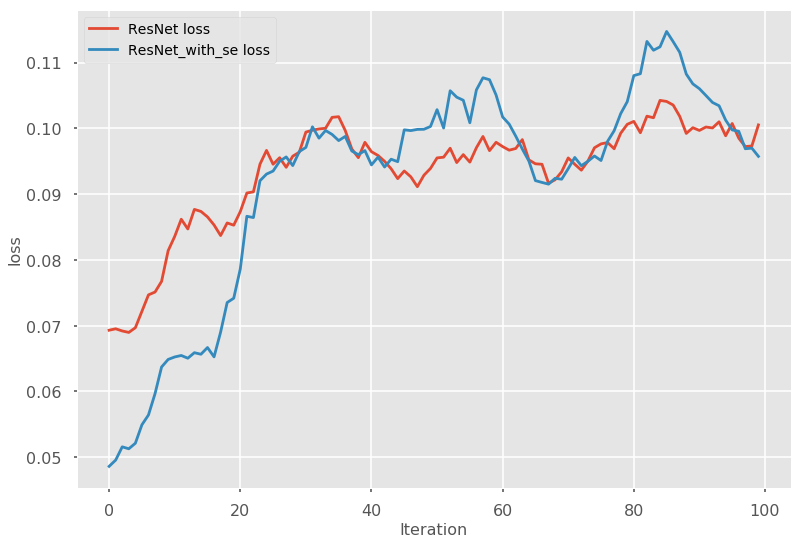

In [9]:
for i in tqn(range(500)):
    res_train_ppl.next_batch(300, n_epochs=None, shuffle=2)
    res_test_ppl.next_batch(300, n_epochs=None, shuffle=2)
    se_train_ppl.next_batch(300, n_epochs=None, shuffle=2)
    se_test_ppl.next_batch(300, n_epochs=None, shuffle=2)
    if i%10==0 and i != 0:
        clear_output(True)
        ResNet_loss = res_test_ppl.get_variable('resloss')[-100:]
        SE_loss = se_test_ppl.get_variable('seloss')[-100:]
        utils.draw(ResNet_loss, 'ResNet', SE_loss, 'ResNet_with_se')
        plt.show()

Let's show the entire learning process

../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


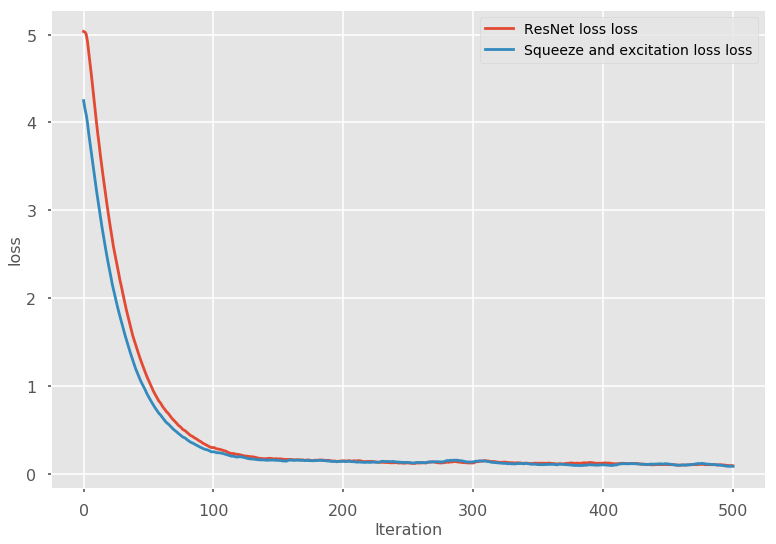

In [14]:
ResNet_loss = res_test_ppl.get_variable('resloss')
SE_loss = se_test_ppl.get_variable('seloss')
utils.draw(ResNet_loss, 'ResNet loss', SE_loss, 'Squeeze and excitation loss')

Not difficult to see, that squeeze and excitation block give better equality than simple resnet. And se_resnet have approximately the same number of parameters SE_resnet(23994378) and simple resnet(23495690).

While SE blocks have been empirically shown to improve network performance, let's understand how the self-gating excitation mechanism operates in practice. To provide a clearer picture of the behaviour of SE blocks, in this section we study example activations from the our SE-ResNet and examine their distribution with respect to different classes at different blocks.

In [11]:
def get_maps(graph, ppl, sess):
    operations = graph.get_operations()
    head_operations = [oper for oper in operations if 'head' in oper.name]
    oper_name = head_operations[1].name + ':0'

    next_batch = ppl.next_batch()
    maps = sess.run(oper_name, feed_dict={'ResNet/inputs/images:0': next_batch.images, 
                                          'ResNet/inputs/labels:0': next_batch.labels,
                                          'ResNet/globals/is_training:0': False})
    return maps, next_batch.labels

In [12]:
res_sess = res_test_ppl.get_model_by_name("resnet").session
res_graph = res_sess.graph

se_sess = se_test_ppl.get_model_by_name('se_block').session
se_graph = se_sess.graph

res_maps, res_answers = get_maps(res_graph, res_test_ppl, res_sess)
se_maps, se_answers = get_maps(se_graph, se_test_ppl, se_sess)

../utils.py:160: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  plt.plot(ewma(filters[i], span=350, adjust=False), color=col[i], label=str(i))


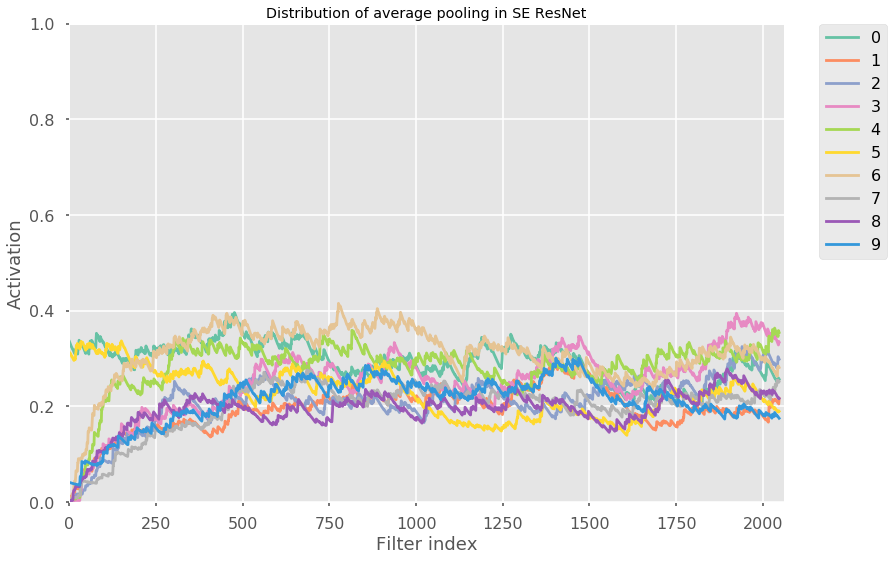

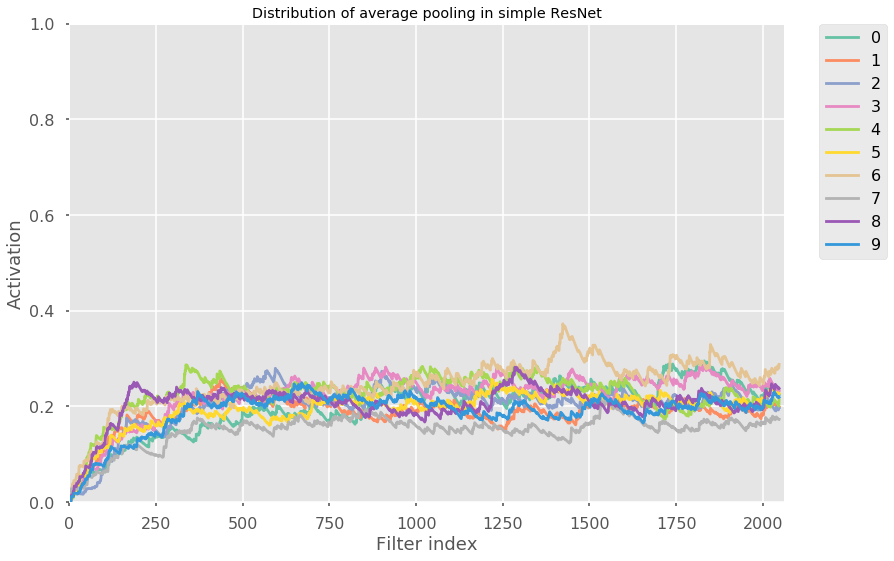

In [13]:
utils.draw_avgpooling(res_maps, res_answers)
utils.draw_avgpooling(se_maps, se_answers, False)

On the graph above each line is distribution of one class.

You can see, that distribution of se_resnet maps bigger, than simple resnet. In this case distribution is distance between lines and the more, the merrier, the network make a choice.